In [1]:
import numpy as np
import pandas as pd
import os

params = pd.read_csv('./params.txt', sep = " ", header=None).to_numpy()
num_exps_, num_params_ = params.shape 
params = params.tolist()
for i in range(num_exps_):
    for j in range(num_params_ ):
        if j == (num_params_ - 1):
            params[i][j] = str(int(params[i][j]))
        else:
            params[i][j] = f'{params[i][j]:.6f}'
params

[['1.500000', '0.026270', '0.500000', '0'],
 ['1.500000', '0.017512', '1.500000', '0'],
 ['1.500000', '0.014290', '2.500000', '0'],
 ['1.500000', '0.078809', '0.500000', '0'],
 ['1.500000', '0.052537', '1.500000', '0'],
 ['1.500000', '0.042869', '2.500000', '0'],
 ['1.500000', '0.210158', '0.500000', '0'],
 ['1.500000', '0.140098', '1.500000', '0'],
 ['1.500000', '0.114318', '2.500000', '0']]

In [2]:
orderings = ['random', 'morton',  'kdtree', 'hilbert', 'mmd']
cs_set = [1, 10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450] #
bc_set = [2500] #50 500 1500 2000 choose one of it at a time
cs_set_classic = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
# bc_set = [1]
filename_template = 'locs_20000_cs_{}_bc_{}_seed_0_kernel_{}:{}:{}_{}'
file_folder = './log/20k-kl-bc' + str(bc_set[0])
file_folder_classic = './log/20k-kl-classic/'
fig_folder = './fig/20k-kl-bc' + str(bc_set[0])

if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# 20k
dense_llh = [-9089.455874354589468567, 15207.478328703782608500, 36435.962080644865636714, 
            1480.247069393142737681, 46689.730128752387827262, 88427.836103233014000580,
            11220.330297452925151447, 75865.277857565684826113, 136956.187419344205409288]

classic_vecchia = np.zeros([num_exps_, 1, len(cs_set_classic), 1])

for i_param, param in enumerate(params):
    for i_cs, cs in enumerate(cs_set_classic):
        filename = filename_template.format(cs, 20000, param[0], param[1], param[2], 'random')
        file_path = os.path.join(file_folder_classic, filename)
        try:
            with open(file_path, 'r') as file:
                # Use a loop to skip the first line
                file.readline()  # Read and discard the first line
                # Now, read the second line
                second_line = file.readline()
                # print(dense_llh[i], float(second_line.split(",")[4]))
                _llh = dense_llh[i_param] - float(second_line.split(",")[4])
                classic_vecchia[i_param, 0, i_cs, 0] = _llh
        except FileNotFoundError:
            print(f"File {filename} not found")

allh = np.zeros([num_exps_, len(orderings), len(cs_set), len(bc_set)])

for i_param, param in enumerate(params):
    for i_ord, ord in enumerate(orderings):
        for i_cs, cs in enumerate(cs_set):
            for i_bc, bc in enumerate(bc_set):
                filename = filename_template.format(cs, bc, param[0], param[1], param[2], ord)
                file_path = os.path.join(file_folder, filename)
                try:
                    with open(file_path, 'r') as file:
                        # Use a loop to skip the first line
                        file.readline()  # Read and discard the first line
                        # Now, read the second line
                        second_line = file.readline()
                        # print(dense_llh[i], float(second_line.split(",")[4]))
                        llh = dense_llh[i_param] - float(second_line.split(",")[4])
                        allh[i_param, i_ord, i_cs, i_bc] = llh
                except FileNotFoundError:
                    print(f"File {filename} not found")

print("Cluster vecchia KL shape", allh.shape)
print("Classic vecchia KL shape", classic_vecchia.shape)

Cluster vecchia KL shape (9, 5, 17, 1)
Classic vecchia KL shape (9, 1, 16, 1)


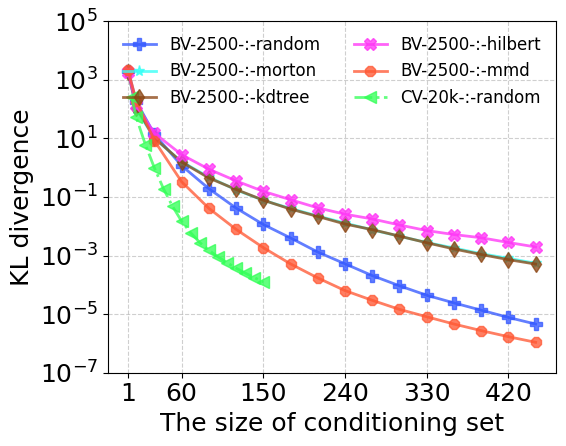

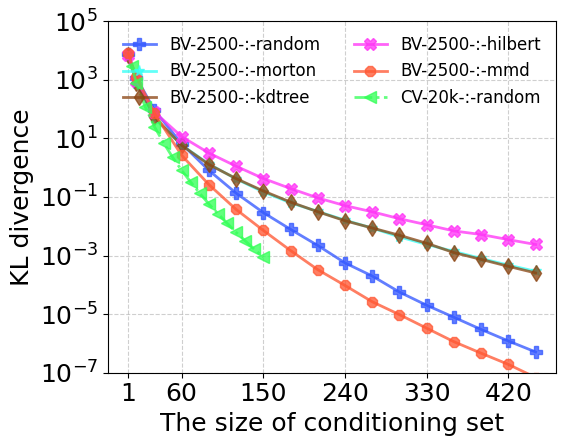

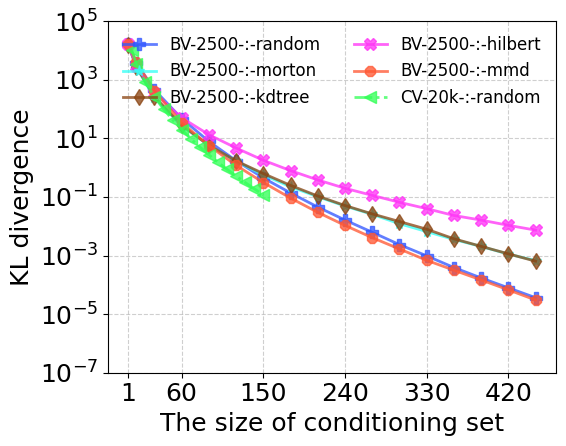

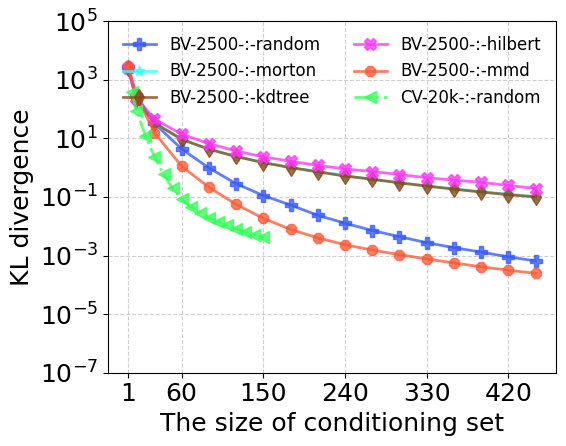

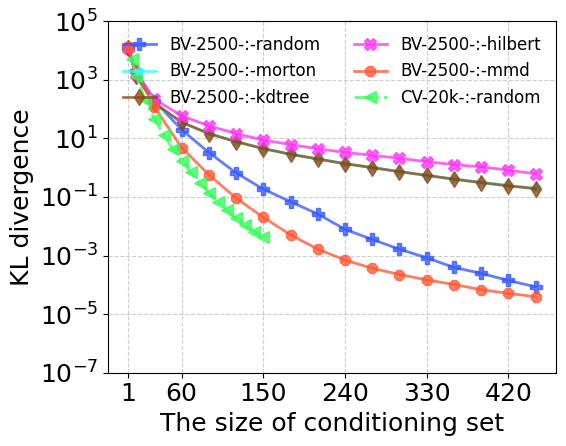

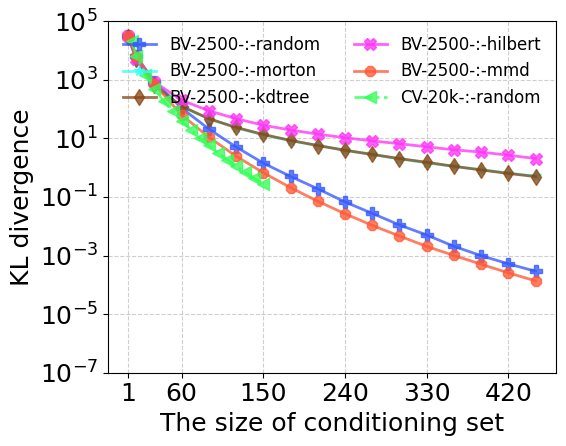

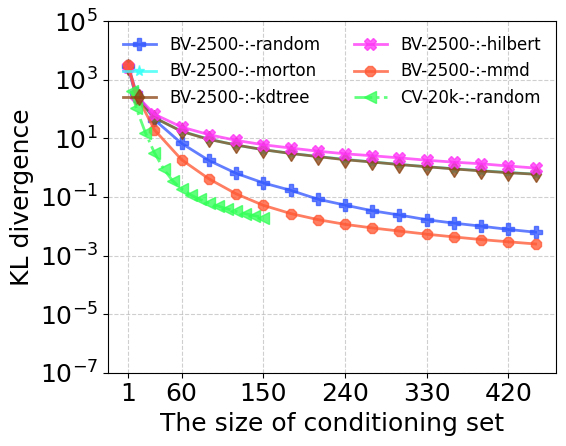

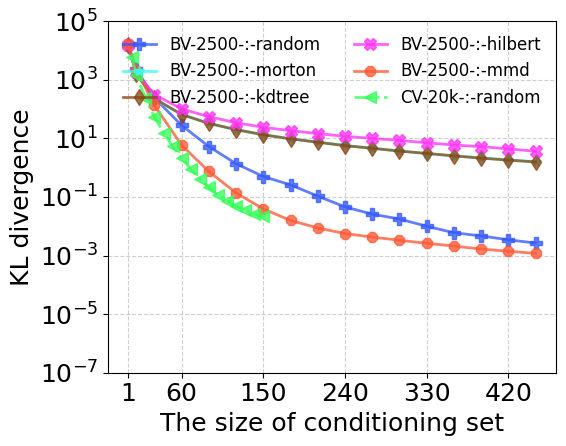

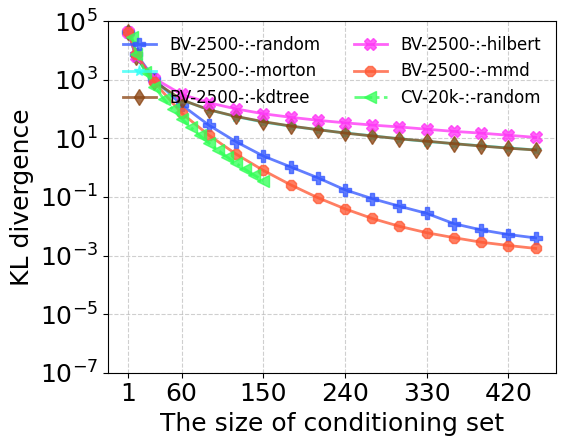

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.size'] = 18  # You can set any numeric value here

fig_dir = './fig'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

markers = ['P', '*', 'd', 'X', '8', '<', '>', '^', 's']
colors = [
    "#3357FF",  # Royal blue
    "#33FFF6",  # Cyan
    "#8B4513",  # Saddle brown
    "#FF33F6",  # Magenta
    "#FF5733",  # Reddish-orange
    "#33FF57",  # Bright green
    "#FF69B4",   # Hot pink
    "#F6FF33",  # Yellow
]
linestyles = ['-', '-.', '--']

ymax = np.max(allh)
ymin = np.min(allh)

def plot_kl(cs_set, bc_set, yy, info, i):
    fig, ax = plt.subplots(figsize=(6, 4.8))
    # fig, ax = plt.subplots(figsize=(6, 6))
    for i_ord, ord in enumerate(orderings):
        for i_bc, bc in enumerate(bc_set):
            ax.plot(cs_set, yy[i_ord, :, i_bc], label="BV-" + str(bc) + "-:-" + str(ord), 
                    linewidth=2, color=colors[i_ord], 
                    linestyle=linestyles[i_bc], alpha=0.77,
                    marker=markers[i_ord], markersize=8)
    # classic Vecchia
    ax.plot(cs_set_classic, classic_vecchia[i, 0, :, 0], label="CV-" + str('20k') + "-:-random", 
                    linewidth=2, color=colors[i_ord+1], 
                    linestyle=linestyles[i_bc+1], alpha=0.77,
                    marker=markers[i_ord+1], markersize=8)
    # ax.scatter(30, classic_vecchia[i, 0], c='red', marker="H", s=40)
    # ax.scatter(60, classic_vecchia[i, 1], c='red', marker="H", s=40)
    ax.set_xlabel('The size of conditioning set')
    ax.set_ylabel('KL divergence')
    ax.set_ylim(1e-7, 1e5)
    ax.set_yscale('log')
    # if (info[1] == '0.114318'):
    # Adding enhanced legend, title, and labels
    legend = ax.legend(ncol = 2, fontsize=12, loc='upper center')
                        #, bbox_to_anchor=(0.5, -0.5) )
                        # title = 'Conditioning size') #loc='lower center', bbox_to_anchor=(0.5, -0.3) 
    legend.get_frame().set_alpha(0.)  # 50% transparency
    # ax.legend(fontsize=12, shadow=True, frameon=True, ) #, title = 'Block size'
    ax.grid(True, linestyle='--', alpha=0.6)
    _list_xtick = cs_set[::3]
    plt.xticks(_list_xtick, _list_xtick)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_folder, f'{info[1]}_{info[2]}.pdf'))
    # plt.show()

for i in range(num_exps_):
    plot_kl(cs_set, bc_set, allh[i, :, :, :], params[i], i)